# Data Augmentation

This notebook shows how we have used data augmentation in an attempt to eliviate the data imbalance. With the help of LLMs and other more typical methods we attempt to manipulate the distribution of labels in an attempt to help the model better generalise. 

In [36]:
# df = pd.read_csv('/Users/rt853/UoB-HICCS-2025/data/brown_corpus_documents.csv')

In [37]:
# import hashlib


# dataset = {
#     'text' : [],
#     'category' : [],
#     'document_id' : [],
#     'line_id' : []
# }

# for idx, row in tqdm(df.iterrows(), total=len(df)):
#     # Create a unique document ID for each row
#     doc_hash = hashlib.md5(str(str(idx) + row['text'] + row['category']).encode()).hexdigest()

#     for idx1, line in enumerate(row.text.split('. ')):
#         dataset['text'].append(line)
#         dataset['category'].append(row['category'])
#         dataset['document_id'].append(doc_hash)
#         dataset['line_id'].append(idx1)
#     # if i
# df = pd.DataFrame(dataset)

In [38]:
# for classname in ['government', 'hobbies', 'humor', 'science_fiction', 'romance']:
#     if classname in df['category'].values:
#         pos_d = df[df['category'] == classname]
#         neg_d = df[df['category'] != classname]
#         pos_d['binary'] = 1
#         neg_d['binary'] = 0
#         temp_d = pd.concat([pos_d, neg_d])
#         temp_d.to_csv('/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/brown/{classname}_binary.csv'.format(classname=classname), index=False)
        

In [39]:
import sys 
import pandas as pd 
from tqdm.auto import tqdm

sys.path.append('../src')

from data_processing.utils import *
from data_processing.data_augmentation import *
import os 

In [54]:
category = 'hobbies'

root_df = pd.read_csv(f'/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/brown/{category}_binary.csv')
root_df.head()

,text,category,document_id,line_id,binary
0,The controversy of the last few years over whe...,hobbies,caaafa2d5791478d63b751a2bd39d85e,0,1
1,The architects do not believe that the educati...,hobbies,caaafa2d5791478d63b751a2bd39d85e,1,1
2,Ordinary politeness may have militated against...,hobbies,caaafa2d5791478d63b751a2bd39d85e,2,1
3,It is true that most architectural schools hav...,hobbies,caaafa2d5791478d63b751a2bd39d85e,3,1
4,The element of public danger which enters so l...,hobbies,caaafa2d5791478d63b751a2bd39d85e,4,1


In [55]:
num_docs = root_df.document_id.nunique()
num_sentences = root_df.text.nunique()

print('Number of documents: ', num_docs)
print('Number of sentences: ', num_sentences)

Number of documents:  500
Number of sentences:  52664


## Augmentation Using LLM 

For the next few cells to work you need to have Ollama installed and be running a model vial 
`ollama run phi3:14b` 

Instructions on how to install can be found: [here](https://ollama.com/)

Once installed it is possible to run different LLMs that can be found on the website 

In [56]:
prompt = """
I am going to show you a text. I want you to to rewrite it as similar as possible 
but with small differences to the words. Consider using synonyms, changing the order as long 
as the semantic meaning is the same. The purpose is to create training data for a classification task.
The text is: "
"""

def prompt_header():
    return """
    I am going to show you a text. I want you to to rewrite it as similar as possible 
    but with small differences to the words. Consider using synonyms, changing the order as long 
    as the semantic meaning is the same. The purpose is to create training data for a classification task.
    The text is: "
    """

def prompt_tail(text_length):
    return f"""
    " remember to keep the length of the text similar to the original which is {text_length} words
    """
    
model = init_olama('phi3:14b')

pos_docs = root_df[root_df['binary'] == 1]

print('Number of positive documents: ', pos_docs.document_id.nunique())
print('Number of positive sentences: ', pos_docs.text.nunique())
print('50% of positive documents: ', int(pos_docs.document_id.nunique() * 0.5))

f0perc = int(pos_docs.document_id.nunique() * 0.5)

Number of positive documents:  36
Number of positive sentences:  3670
50% of positive documents:  18


## Augmenting the Brown Corpus 

I think it would be best to augment full documents as not all sentences could be indicative of the whole category. In this case I will augment up to 50% of the total positive documents.

In [57]:
import random

# Get unique document IDs
unique_docs = pos_docs.document_id.unique()
random_docs = random.sample(list(unique_docs), f0perc)


aug_path = f'/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/augmented/{category}_binary.csv'

if os.path.exists(aug_path):
    augmented_df = pd.read_csv(aug_path)
else:
    augmented_df = pd.DataFrame(columns=['text', 'category', 'document_id', 'line_id', 'augmented_text'])

aug_df = {
    'text' : [],
    'category' : [],
    'document_id' : [],
    'new_document_id' : [],
    'line_id' : [],
    'augmented_text' : [],
}

line_counter = 0
for doc_id in tqdm(random_docs):
    doc_df = pos_docs[pos_docs['document_id'] == doc_id]
    for idx, row in tqdm(doc_df.iterrows(), total=len(doc_df)):
        if row['text'] in augmented_df.text.values:
            print('Already exists: ', row['text'])
            continue
        try:
            aug_text = model.invoke(prompt_header() + row['text'] + prompt_tail(len(row['text'].split())))
        except:
            continue 
        aug_df['text'].append(row['text'])
        aug_df['document_id'].append(row['document_id'])
        aug_df['category'].append(row['category'])
        aug_df['line_id'].append(row['line_id'])
        aug_df['augmented_text'].append(aug_text)
        aug_df['new_document_id'].append(row['document_id'] + '_aug')
        line_counter += 1
        
        if line_counter % 5 == 0:
            print('Number of lines processed: ', line_counter)
            pd.DataFrame(aug_df).to_csv(aug_path, index=False)
            
            
    


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

Number of lines processed:  5
Number of lines processed:  10
Number of lines processed:  15
Number of lines processed:  20
Number of lines processed:  25
Number of lines processed:  30
Number of lines processed:  35
Number of lines processed:  40
Number of lines processed:  45
Number of lines processed:  50
Number of lines processed:  55
Number of lines processed:  60
Number of lines processed:  65
Number of lines processed:  70
Number of lines processed:  75
Number of lines processed:  80
Number of lines processed:  85


  0%|          | 0/84 [00:00<?, ?it/s]

Number of lines processed:  90
Number of lines processed:  95
Number of lines processed:  100
Number of lines processed:  105
Number of lines processed:  110
Number of lines processed:  115
Number of lines processed:  120
Number of lines processed:  125
Number of lines processed:  130
Number of lines processed:  135
Number of lines processed:  140
Number of lines processed:  145
Number of lines processed:  150
Number of lines processed:  155
Number of lines processed:  160
Number of lines processed:  165
Number of lines processed:  170


  0%|          | 0/90 [00:00<?, ?it/s]

Number of lines processed:  175
Number of lines processed:  180
Number of lines processed:  185
Number of lines processed:  190
Number of lines processed:  195
Number of lines processed:  200
Number of lines processed:  205
Number of lines processed:  210
Number of lines processed:  215
Number of lines processed:  220
Number of lines processed:  225
Number of lines processed:  230
Number of lines processed:  235
Number of lines processed:  240
Number of lines processed:  245
Number of lines processed:  250
Number of lines processed:  255


  0%|          | 0/138 [00:00<?, ?it/s]

Number of lines processed:  260
Number of lines processed:  265
Number of lines processed:  270
Number of lines processed:  275
Number of lines processed:  280
Number of lines processed:  285
Number of lines processed:  290
Number of lines processed:  295
Number of lines processed:  300
Number of lines processed:  305
Number of lines processed:  310
Number of lines processed:  315
Number of lines processed:  320
Number of lines processed:  325
Number of lines processed:  330
Number of lines processed:  335
Number of lines processed:  340
Number of lines processed:  345
Number of lines processed:  350
Number of lines processed:  355
Number of lines processed:  360
Number of lines processed:  365
Number of lines processed:  370
Number of lines processed:  375
Number of lines processed:  380
Number of lines processed:  385
Number of lines processed:  390


  0%|          | 0/92 [00:00<?, ?it/s]

Number of lines processed:  395
Number of lines processed:  400
Number of lines processed:  405
Number of lines processed:  410
Number of lines processed:  415
Number of lines processed:  420
Number of lines processed:  425
Number of lines processed:  430
Number of lines processed:  435
Number of lines processed:  440
Number of lines processed:  445
Number of lines processed:  450
Number of lines processed:  455
Number of lines processed:  460
Number of lines processed:  465
Number of lines processed:  470
Number of lines processed:  475
Number of lines processed:  480
Number of lines processed:  485


  0%|          | 0/119 [00:00<?, ?it/s]

Number of lines processed:  490
Number of lines processed:  495
Number of lines processed:  500
Number of lines processed:  505
Number of lines processed:  510
Number of lines processed:  515
Number of lines processed:  520
Number of lines processed:  525
Number of lines processed:  530
Number of lines processed:  535
Number of lines processed:  540
Number of lines processed:  545
Number of lines processed:  550
Number of lines processed:  555
Number of lines processed:  560
Number of lines processed:  565
Number of lines processed:  570
Number of lines processed:  575
Number of lines processed:  580
Number of lines processed:  585
Number of lines processed:  590
Number of lines processed:  595
Number of lines processed:  600
Number of lines processed:  605


  0%|          | 0/155 [00:00<?, ?it/s]

Number of lines processed:  610
Number of lines processed:  615
Number of lines processed:  620
Number of lines processed:  625
Number of lines processed:  630
Number of lines processed:  635
Number of lines processed:  640
Number of lines processed:  645
Number of lines processed:  650
Number of lines processed:  655
Number of lines processed:  660
Number of lines processed:  665
Number of lines processed:  670
Number of lines processed:  675
Number of lines processed:  680
Number of lines processed:  685
Number of lines processed:  690
Number of lines processed:  695
Number of lines processed:  700
Number of lines processed:  705
Number of lines processed:  710
Number of lines processed:  715
Number of lines processed:  720
Number of lines processed:  725
Number of lines processed:  730
Number of lines processed:  735
Number of lines processed:  740
Number of lines processed:  745
Number of lines processed:  750
Number of lines processed:  755
Number of lines processed:  760


  0%|          | 0/109 [00:00<?, ?it/s]

Number of lines processed:  765
Number of lines processed:  770
Number of lines processed:  775
Number of lines processed:  780
Number of lines processed:  785
Number of lines processed:  790
Number of lines processed:  795
Number of lines processed:  800
Number of lines processed:  805
Number of lines processed:  810
Number of lines processed:  815
Number of lines processed:  820
Number of lines processed:  825
Number of lines processed:  830
Number of lines processed:  835
Number of lines processed:  840
Number of lines processed:  845
Number of lines processed:  850
Number of lines processed:  855
Number of lines processed:  860
Number of lines processed:  865


  0%|          | 0/114 [00:00<?, ?it/s]

Number of lines processed:  870
Number of lines processed:  875
Number of lines processed:  880
Number of lines processed:  885
Number of lines processed:  890
Number of lines processed:  895
Number of lines processed:  900
Number of lines processed:  905
Number of lines processed:  910
Number of lines processed:  915
Number of lines processed:  920
Number of lines processed:  925
Number of lines processed:  930
Number of lines processed:  935
Number of lines processed:  940
Number of lines processed:  945
Number of lines processed:  950
Number of lines processed:  955
Number of lines processed:  960
Number of lines processed:  965
Number of lines processed:  970
Number of lines processed:  975
Number of lines processed:  980


  0%|          | 0/93 [00:00<?, ?it/s]

Number of lines processed:  985
Number of lines processed:  990
Number of lines processed:  995
Number of lines processed:  1000
Number of lines processed:  1005
Number of lines processed:  1010
Number of lines processed:  1015
Number of lines processed:  1020
Number of lines processed:  1025
Number of lines processed:  1030
Number of lines processed:  1035
Number of lines processed:  1040
Number of lines processed:  1045
Number of lines processed:  1050
Number of lines processed:  1055
Number of lines processed:  1060
Number of lines processed:  1065
Number of lines processed:  1070
Number of lines processed:  1075


  0%|          | 0/88 [00:00<?, ?it/s]

Number of lines processed:  1080
Number of lines processed:  1085
Number of lines processed:  1090
Number of lines processed:  1095
Number of lines processed:  1100
Number of lines processed:  1105
Number of lines processed:  1110
Number of lines processed:  1115
Number of lines processed:  1120
Number of lines processed:  1125
Number of lines processed:  1130
Number of lines processed:  1135
Number of lines processed:  1140
Number of lines processed:  1145
Number of lines processed:  1150
Number of lines processed:  1155
Number of lines processed:  1160


  0%|          | 0/74 [00:00<?, ?it/s]

Number of lines processed:  1165
Number of lines processed:  1170
Number of lines processed:  1175
Number of lines processed:  1180
Number of lines processed:  1185
Number of lines processed:  1190
Number of lines processed:  1195
Number of lines processed:  1200
Number of lines processed:  1205
Number of lines processed:  1210
Number of lines processed:  1215
Number of lines processed:  1220
Number of lines processed:  1225
Number of lines processed:  1230
Number of lines processed:  1235


  0%|          | 0/109 [00:00<?, ?it/s]

Number of lines processed:  1240
Number of lines processed:  1245
Number of lines processed:  1250
Number of lines processed:  1255
Number of lines processed:  1260
Number of lines processed:  1265
Number of lines processed:  1270
Number of lines processed:  1275
Number of lines processed:  1280
Number of lines processed:  1285
Number of lines processed:  1290
Number of lines processed:  1295
Number of lines processed:  1300
Number of lines processed:  1305
Number of lines processed:  1310
Number of lines processed:  1315
Number of lines processed:  1320
Number of lines processed:  1325
Number of lines processed:  1330
Number of lines processed:  1335
Number of lines processed:  1340
Number of lines processed:  1345


  0%|          | 0/98 [00:00<?, ?it/s]

Number of lines processed:  1350
Number of lines processed:  1355
Number of lines processed:  1360
Number of lines processed:  1365
Number of lines processed:  1370
Number of lines processed:  1375
Number of lines processed:  1380
Number of lines processed:  1385
Number of lines processed:  1390
Number of lines processed:  1395
Number of lines processed:  1400
Number of lines processed:  1405
Number of lines processed:  1410
Number of lines processed:  1415
Number of lines processed:  1420
Number of lines processed:  1425
Number of lines processed:  1430
Number of lines processed:  1435
Number of lines processed:  1440


  0%|          | 0/87 [00:00<?, ?it/s]

Number of lines processed:  1445
Number of lines processed:  1450
Number of lines processed:  1455
Number of lines processed:  1460
Number of lines processed:  1465
Number of lines processed:  1470
Number of lines processed:  1475
Number of lines processed:  1480
Number of lines processed:  1485
Number of lines processed:  1490
Number of lines processed:  1495
Number of lines processed:  1500
Number of lines processed:  1505
Number of lines processed:  1510
Number of lines processed:  1515
Number of lines processed:  1520
Number of lines processed:  1525
Number of lines processed:  1530


  0%|          | 0/105 [00:00<?, ?it/s]

Number of lines processed:  1535
Number of lines processed:  1540
Number of lines processed:  1545
Number of lines processed:  1550
Number of lines processed:  1555
Number of lines processed:  1560
Number of lines processed:  1565
Number of lines processed:  1570
Number of lines processed:  1575
Number of lines processed:  1580
Number of lines processed:  1585
Number of lines processed:  1590
Number of lines processed:  1595
Number of lines processed:  1600
Number of lines processed:  1605
Number of lines processed:  1610
Number of lines processed:  1615
Number of lines processed:  1620
Number of lines processed:  1625
Number of lines processed:  1630
Number of lines processed:  1635


  0%|          | 0/143 [00:00<?, ?it/s]

Number of lines processed:  1640
Number of lines processed:  1645
Number of lines processed:  1650
Number of lines processed:  1655
Number of lines processed:  1660
Number of lines processed:  1665
Number of lines processed:  1670
Number of lines processed:  1675
Number of lines processed:  1680
Number of lines processed:  1685
Number of lines processed:  1690
Number of lines processed:  1695
Number of lines processed:  1700
Number of lines processed:  1705
Number of lines processed:  1710
Number of lines processed:  1715
Number of lines processed:  1720
Number of lines processed:  1725
Number of lines processed:  1730
Number of lines processed:  1735
Number of lines processed:  1740
Number of lines processed:  1745
Number of lines processed:  1750
Number of lines processed:  1755
Number of lines processed:  1760
Number of lines processed:  1765
Number of lines processed:  1770
Number of lines processed:  1775


  0%|          | 0/121 [00:00<?, ?it/s]

Number of lines processed:  1780
Number of lines processed:  1785
Number of lines processed:  1790
Number of lines processed:  1795
Number of lines processed:  1800
Number of lines processed:  1805
Number of lines processed:  1810
Number of lines processed:  1815
Number of lines processed:  1820
Number of lines processed:  1825
Number of lines processed:  1830
Number of lines processed:  1835
Number of lines processed:  1840
Number of lines processed:  1845
Number of lines processed:  1850
Number of lines processed:  1855
Number of lines processed:  1860
Number of lines processed:  1865
Number of lines processed:  1870
Number of lines processed:  1875
Number of lines processed:  1880
Number of lines processed:  1885
Number of lines processed:  1890
Number of lines processed:  1895


In [50]:
import os 

os.path.exists('/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/augmented')

True

In [14]:
from data_processing.data_augmentation import *

The below code can be run to generate a dataframe of augmented samples. You should manually inspect the data as there can be reduntant langauge such as the model telling you its thought process or other random annecdotes. We recoomend using a post processing script.

In [ ]:
aug_data = pd.read_csv('/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/augmented_government.csv')


,class
count,660.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [28]:
input_sample = root_df[root_df[class_col]==positive].sample(1).iloc[0][text_col]

In [34]:
input_sample

'FREE camera phones with linerental from 4.49/month with 750 cross ntwk mins. 1/2 price txt bundle deals also avble. Call 08001950382 or call2optout/J MF'

In [29]:
prompt = f"""I am showing you a spam message, can you rewrite it as similar as possible bearing in mind 
the purpose is to generate training data for a spam detection model: "{input_sample}"."""

In [7]:
augmented_d.to_csv('/Users/rt853/UoB-persuasion-detection/data/processed/rapoport_augmented_data_final.csv')

In [14]:
from transformers import RobertaTokenizer, RobertaModel
import torch

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Encode the text column
def encode_text(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Mean pooling of token embeddings

# Apply encoding to the text column



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(augmented_d.text[0])
print(augmented_d.root_text[0])

"Building training data can indeed pose a challenge; not everyone realizes its importance or shows interest."
persuader: it is actually kind of hard. many do not see the need or care.


In [10]:

encoded_aug = encode_text(augmented_d.text.tolist())
encoded_root = encode_text(augmented_d.root_text.tolist())

In [11]:
from torch.nn.functional import cosine_similarity

def calculate_cosine_similarity(vector1, vector2):
    similarity = cosine_similarity(vector1, vector2)
    return similarity.item()

# Example usage
vector1 = encoded_aug[0]
vector2 = encoded_root[0]
# similarity = calculate_cosine_similarity(vector1, vector2)
print(f"Cosine Similarity: {similarity}")

NameError: name 'similarity' is not defined

In [ ]:
for idx, row in tqdm(augmented_d.iterrows(), total=len(augmented_d)):
    vector1 = encode_text(row['text'])
    vector2 = encode_text(row['root_text'])
    
 

    similarity = calculate_cosine_similarity(vector1, vector2)
    augmented_d.at[idx, 'cosine_similarity'] = round(similarity,2)

0it [00:00, ?it/s]

In [12]:
import pandas as pd 
df = pd.read_csv('/Users/rt853/UoB-persuasion-detection/data/processed/rapport_augmented_data.csv')

In [24]:
from transformers import RobertaTokenizer, RobertaModel

df['root_embeddings'] = df['root_text'].apply(lambda x: encode_text(x))

In [25]:

df['aug_embeddings'] = df['text'].apply(lambda x: encode_text(x))

In [80]:
import numpy as np 

tsbe_samples = df.sample(30)
root_embeddings = tsbe_samples['root_embeddings'].tolist()
aug_embeddings = tsbe_samples['aug_embeddings'].tolist()
embeddings = np.vstack(root_embeddings + aug_embeddings)

In [81]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(embeddings)

In [82]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings)

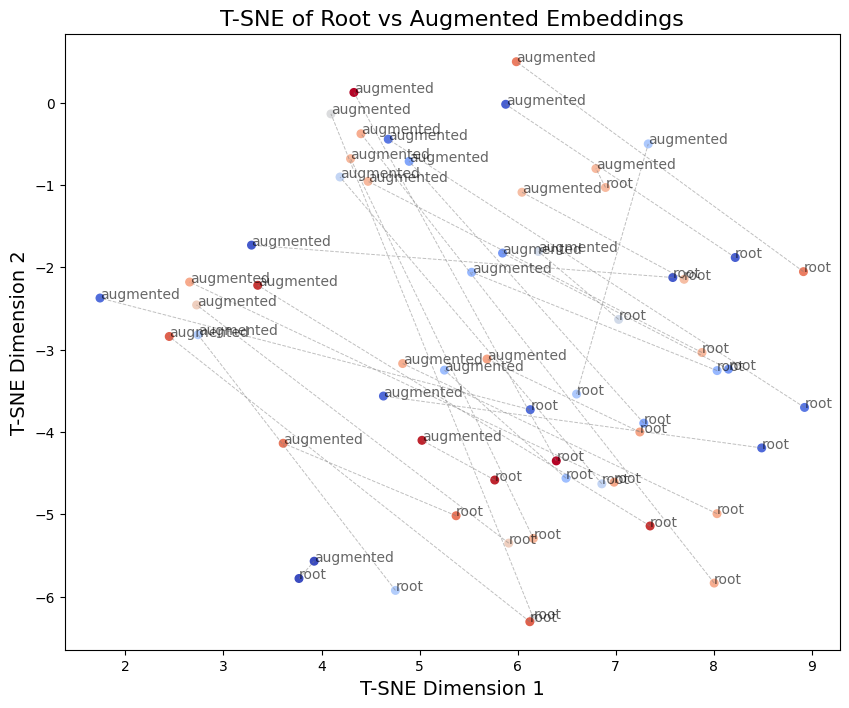

In [87]:
import matplotlib.pyplot as plt

# Create labels for root vs augmented embeddings
labels = ['root'] * len(tsbe_samples) + ['augmented'] * len(tsbe_samples)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=(list(tsbe_samples.index) + list(tsbe_samples.index)), cmap='coolwarm', s=30)

plt.title('T-SNE of Root vs Augmented Embeddings', fontsize=16)

# Annotate points
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=10, alpha=0.6)
    
# Draw lines between corresponding pairs
for i in range(len(tsbe_samples)):
    plt.plot([tsne_result[i, 0], tsne_result[i + len(tsbe_samples), 0]],
             [tsne_result[i, 1], tsne_result[i + len(tsbe_samples), 1]],
             color='gray', alpha=0.5, linestyle='--', linewidth=0.7)

plt.xlabel('T-SNE Dimension 1', fontsize=14)
plt.ylabel('T-SNE Dimension 2', fontsize=14)
plt.savefig('./tsne_plot.png')

plt.show()